# 1. Importando as bibliotecas

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt

# 2. Funções

In [3]:
def calc_retorno(preco_final, preco_inicial):
    return (preco_final - preco_inicial)/preco_inicial

def mostrar_desempenho(cotacao, ticker, data_inicio, data_final, plot_grafico=True, return_retorno=True):
    # Cálculo do Retorno
    preco_inicial = cotacao.loc[data_inicio][-1]
    preco_final = cotacao.loc[data_final][-1]
    retorno = calc_retorno(preco_final, preco_inicial)
    cor_desempenho = "green" if retorno > 0 else "red"    
    
    if plot_grafico:
        # Filtro 
        cotacao_filtrada = cotacao.loc[(cotacao.index >= data_inicio) & (cotacao.index <= data_final)]
        
        # Gráfico
        plt.figure(figsize=(12,5))
        plt.title(f"Cotação: {ticker} - Retorno = {retorno:.2%}")
        sns.lineplot(x=cotacao_filtrada.index, y=cotacao_filtrada['Close'], color=cor_desempenho, alpha=0.8)
        plt.fill_between(cotacao_filtrada.index, cotacao_filtrada['Close'], color=cor_desempenho, alpha=0.1)
        plt.ylabel('Cotação')
        sns.despine()
        plt.savefig("imagens\desempenho de um ativo.png")
        plt.show()           
    else:
        print(f"Período: {data_inicio} à {data_final}")
        print(f"O desempenho do ativo nesse período foi de: {retorno:.2%}")
        
    if return_retorno:
        return retorno

In [4]:
def plot_fator(cotacao, data_inicio, data_final, return_fator=True):
    # Filtrando o histórico
    if not(data_final):
        cotacao = cotacao.loc[cotacao.index >= data_inicio]
    else:
        cotacao = cotacao.loc[(cotacao.index >= data_inicio) & (cotacao.index <= data_final)]
    
    # Cotação normalizada
    cotacao_norm = cotacao/cotacao.iloc[0]
    
    # Fator de multiplicação do capital
    fator = cotacao_norm.iloc[-1][-1]
        
    # Gráfico
    plt.figure(figsize=(12,5))
    plt.title(f"Multiplicação de Capital = {fator:.2%}")
    sns.lineplot(x=cotacao_norm.index, y=cotacao_norm['Close'])
    plt.ylabel(f'Índice (Base: {cotacao_norm.index[0].date()})')    
    sns.despine()
    plt.savefig("imagens\Multiplicação.png")
    plt.show()         
    
    if return_fator:
        return fator

In [7]:
def retorno_carteira(carteira:dict, inicio:'data', fim:'data'= None, plot_grafico=True, return_dados=False, plot_perf_ativos=False):
    # Pegando o ticker de cada ativo na carteira
    ativos = list(carteira.keys())
    
    # Carrengado a cotação e selecionando o período desejado
    precos = yf.download(ativos, progress=False)['Close']
    precos_filtro = precos[(precos.index >= inicio) & (precos.index <= fim)]
    
    # Computando a quantidade real de ativos comprados
    carteira_ativos = pd.Series(data=carteira)
    precos_inicio = precos_filtro.iloc[0]
    precos_final = precos_filtro.iloc[-1]
    qtde_ativos = round(carteira_ativos/precos_inicio, 0)
    
    # Variação da carteira e Patrimônio total investido
    PL_carteira = precos_filtro * qtde_ativos
    PL_carteira['PL TOTAL'] = PL_carteira.sum(axis=1)
    pesos_ativos = PL_carteira[ativos].iloc[0]/PL_carteira[ativos].iloc[0].sum()    
    
    # Calculando o retorno da Carteira e o Rendimento do período
    valor_inicial = PL_carteira['PL TOTAL'].iloc[0]
    valor_final = PL_carteira['PL TOTAL'].iloc[-1]    
    retorno_carteira = (valor_final - valor_inicial)/valor_inicial
    rendimento = retorno_carteira * valor_inicial    
    retornos_ativos = (PL_carteira.iloc[-1] - PL_carteira.iloc[0])/PL_carteira.iloc[0]    
    cor_desempenho = "green" if retorno_carteira > 0 else "red" 

    ### CONFIGURAÇÕES DO GRÁFICO    
    if plot_grafico:
        plt.figure(figsize=(12,5))
        plt.title(f'Retorno da Carteira no período = {retorno_carteira:.2%} (R$ {rendimento:,.2f})')
        sns.lineplot(x=PL_carteira.index, y=PL_carteira['PL TOTAL'], color=cor_desempenho, alpha=0.8)
        plt.fill_between(PL_carteira.index, PL_carteira['PL TOTAL'], color=cor_desempenho, alpha=0.1)

        plt.annotate(f'R$ {valor_inicial:,.2f}', 
                     xy=(PL_carteira.index[0], valor_inicial), 
                     xytext=(0, 30),
                     textcoords='offset points', 
                     arrowprops=dict(facecolor='black', arrowstyle='->'), 
                     fontsize=11, color='black')

        plt.annotate(f'R$ {valor_final:,.2f}', 
                     xy=(PL_carteira.index[-1], valor_final), 
                     xytext=(0, 20),  
                     textcoords='offset points', 
                     arrowprops=dict(facecolor='black', arrowstyle='->'),  
                     fontsize=11, color='black')

        sns.despine()
        plt.savefig("imagens\desempenho da carteira.png")        
        plt.show()  
        
    if return_dados:
        # Performance dos ativos
        performance_ativos = pd.concat(
            [precos_inicio, precos_final, PL_carteira.iloc[0], PL_carteira.iloc[-1], qtde_ativos, pesos_ativos, retornos_ativos*100], axis=1, join='inner',
            keys=['Preço Início', 'Preço Final', 'PL Inicial', 'PL Final', 'Quantidade','Peso','Retorno(%)'])

        # Performance da carteira
        pmi_c = (precos_inicio*qtde_ativos).sum()/qtde_ativos.sum()
        pmf_c = (precos_final*qtde_ativos).sum()/qtde_ativos.sum()
        pli_c = (precos_inicio*qtde_ativos).sum()
        plf_c = (precos_final*qtde_ativos).sum()        
        qtd_c = qtde_ativos.sum()
        peso_c = pesos_ativos.sum()
        retorno_c = (retornos_ativos*pesos_ativos).sum()*100

        performance_carteira = pd.DataFrame(
            data=[[pmi_c, pmf_c, pli_c, plf_c, qtd_c, peso_c, retorno_c]],                                 
            columns=['Preço Início', 'Preço Final', 'PL Inicial', 'PL Final', 'Quantidade','Peso','Retorno(%)'], index=['Carteira'])

        # Juntando as performaces    
        return PL_carteira, pd.concat([performance_ativos, performance_carteira], axis=0)
    
    if plot_perf_ativos:
        price_ativos = PL_carteira[ativos]
        price_ativos_norm = price_ativos/price_ativos.iloc[0]
        
        # Remover os ativos que não possuem preços
        prices_ok = list(price_ativos_norm.iloc[0][price_ativos_norm.iloc[0] > 0].index)        
    
        plt.figure(figsize=(12,5))
        plt.title('Performance de cada ativos durante o período')
        for ticker in prices_ok:
            sns.lineplot(x=price_ativos_norm.index, y=price_ativos_norm[ticker], label=ticker, alpha=0.8)
        plt.xlabel('performance dos ativos')
        plt.ylabel('Índice')        
        sns.despine()
        plt.savefig("imagens\performance ativos.png")        
        plt.show()          

# 2. Retorno Histórico

## 2.1 De um Ativo

 ### Analisando as ações da BBAS3
* Período: 31/01/2020 à 30/01/2025

In [74]:
# Importando os dados sobre a ação
ativo = 'BBAS3.SA'
dados_acao = yf.download(ativo, progress=False)
price = dados_acao[['Close']]
datas_possiveis = price.index

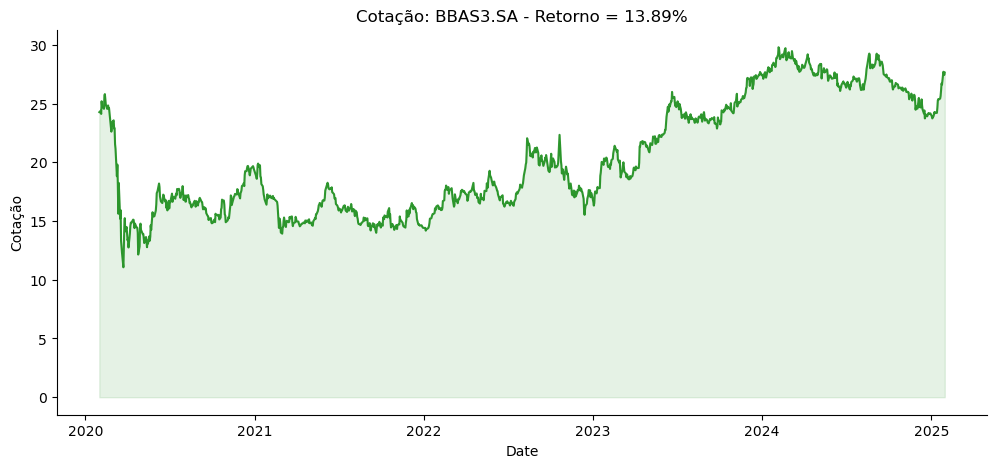

In [77]:
if (dt_inicio in datas_possiveis) & (dt_inicio in datas_possiveis):
    # As datas são válidas
    retorno_periodo = mostrar_desempenho(cotacao=price, ticker=ativo, data_inicio="2020-01-31", data_final="2025-01-30")
else:
    print('As datas não estão disponíveis!')

* Outra forma de analisar o desempenho no período, é calculando o fator de multplicação de capital. Basicamente, para descobrir o valor que teriámos no final do período, bastaria multiplicar o valor investido por esse fator.

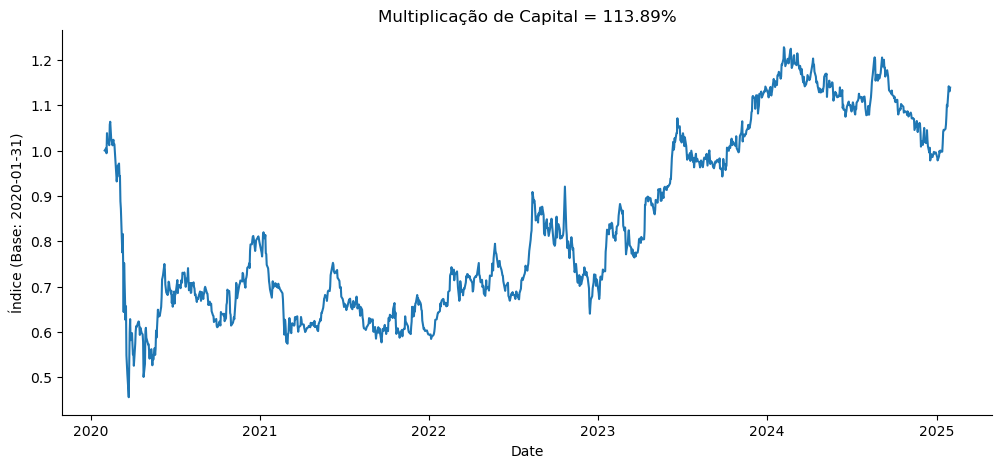

In [58]:
fator_periodo = plot_fator(cotacao=price, data_inicio=dt_inicio, data_final=dt_fim)

Suponha que você tenha aplicado R\$1000,00 no início desse período:

In [59]:
valor_aplicado = 1000

In [60]:
valor_retorno = retorno_periodo * valor_aplicado
print(f"Retorno(%) = {retorno_periodo:.2%}")
print(f"Em reais: R$ {valor_retorno:,.2f}")

Retorno(%) = 13.89%
Em reais: R$ 138.85


In [61]:
valor_hoje = fator_periodo * valor_aplicado # Ou: Valor Aplicado + Retorno(R$)
print(f"Hoje teriámos = R${valor_hoje:,.2f}")  # 1000 * 0,13885 = R$ 1138,85

Hoje teriámos = R$1,138.85


 ### Analisando as ações da Vale3
 * Período: 30/01/2024 à 30/01/2025

In [72]:
# Importando os dados sobre a ação
ativo2 = 'VALE3.SA'
dados_acao2 = yf.download(ticker, progress=False)
price2 = dados_acao2[['Close']]
datas_possiveis = price2.index

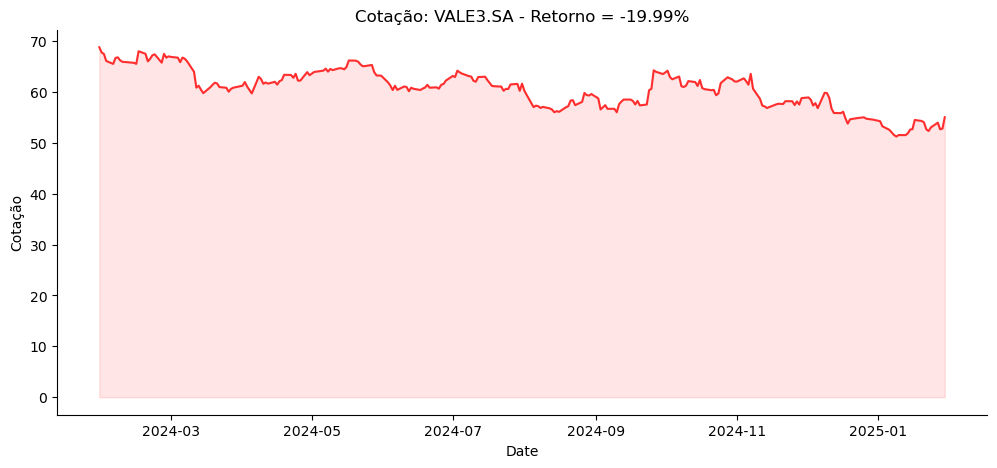

In [76]:
if (dt_inicio in datas_possiveis) & (dt_inicio in datas_possiveis):
    retorno_periodo = mostrar_desempenho(cotacao=price2, ticker=ativo2, data_inicio="2024-01-30", data_final="2025-01-30")
else:
    print('As datas não estão disponíveis!')

Como o retorno foi negativo, isso significa que o nosso capital estaria desvalorizando durante esse período.

## 2.2 De uma Carteira

In [28]:
# Montando carteira
dt_inicio = '2010-01-04'
dt_final = '2025-01-30'

compras = {'VALE3.SA':1000, 'BBAS3.SA':1000, 'AGRO3.SA':2000}

In [29]:
cotacao = yf.download(list(compras.keys()), progress=False)['Close']

# Filtrando os dados para o período especificado
precos_filtro = cotacao[(cotacao.index >= dt_inicio) & (cotacao.index <= dt_final)]  
precos_filtro.head(3)

Ticker,AGRO3.SA,BBAS3.SA,VALE3.SA
Date,,,
2010-01-04,10.2,14.95,51.490002
2010-01-05,10.2,14.80,51.970001
2010-01-06,10.2,14.82,53.070000


In [30]:
# Preços no início do período
pi = precos_filtro.iloc[0]
pi

Ticker
AGRO3.SA    10.200000
BBAS3.SA    14.950000
VALE3.SA    51.490002
Name: 2010-01-04 00:00:00, dtype: float64

In [31]:
# preços no final do período
pf = precos_filtro.iloc[-1]
pf

Ticker
AGRO3.SA    23.049999
BBAS3.SA    27.639999
VALE3.SA    55.029999
Name: 2025-01-30 00:00:00, dtype: float64

In [32]:
compras_df = pd.Series(data=compras)

* Quantidade de ações

In [33]:
# Obtendo a quantidade de ações que realmente teríamos comprado com o valor aplicado
qtde_ativos = round(compras_df/pi, 0)
qtde_ativos

AGRO3.SA    196.0
BBAS3.SA     67.0
VALE3.SA     19.0
dtype: float64

In [12]:
# Variação do valor aplicado em cada ação durante o período
PL = precos_filtro * qtde_ativos

# Criando uma nova coluna que representação a variação da carteira(a soma de todos os ativos)
PL['PL TOTAL'] = PL.sum(axis=1)

In [13]:
# Variação inicial e final 
pd.concat([PL.head(5), PL.tail(5)], axis=0)

Ticker,AGRO3.SA,BBAS3.SA,VALE3.SA,PL TOTAL
Date,,,,
2010-01-04,1999.199963,1001.649987,978.310032,3979.159982
2010-01-05,1999.199963,991.600013,987.430023,3978.229999
2010-01-06,1999.199963,992.939980,1008.329994,4000.469936
2010-01-07,2056.039955,993.274987,1012.510017,4061.824960
2010-01-08,2056.039955,998.969990,1022.390026,4077.399971
2025-01-24,4355.119865,1783.540056,1007.569977,7146.229898
2025-01-27,4427.640030,1856.569939,1025.239983,7309.449951
2025-01-28,4466.840179,1844.510046,1000.350029,7311.700254
2025-01-29,4400.200150,1838.480036,1003.199986,7241.880171


O cálculo do retorno da carteira poderá ser feito de duas formas:

### Forma 01: Pela variação do **PL TOTAL**, pegando o valor da carteira no início e no final do periodo;

In [14]:
vi = PL['PL TOTAL'].iloc[0]
print(f'Valor inicial da carteira: R${vi:,.2f}')

Valor inicial da carteira: R$3,979.16


In [15]:
vf = PL['PL TOTAL'].iloc[-1]
print(f'Valor final da carteira: R${vf:,.2f}')

Valor final da carteira: R$7,415.25


In [16]:
rhc = calc_retorno(vf, vi)
print(f'O Retorno histórico da carteira no período foi de: {rhc:.2%}')

O Retorno histórico da carteira no período foi de: 86.35%


### Forma 02: Pelo somatório do retorno de cada ativo ponderado pela sua participação na carteira;

In [17]:
PL.head(3)

Ticker,AGRO3.SA,BBAS3.SA,VALE3.SA,PL TOTAL
Date,,,,
2010-01-04,1999.199963,1001.649987,978.310032,3979.159982
2010-01-05,1999.199963,991.600013,987.430023,3978.229999
2010-01-06,1999.199963,992.939980,1008.329994,4000.469936


In [18]:
# Veja abaixo o retorno de cada ação, inclusive, da carteira.
retornos = (PL.iloc[-1] - PL.iloc[0])/PL.iloc[0]
retornos

Ticker
AGRO3.SA    1.259804
BBAS3.SA    0.848829
VALE3.SA    0.068751
PL TOTAL    0.863521
dtype: float64

Para confirma, vamos pegas apenas de cada ação e depois realizar a soma ponderada.

In [19]:
retornos = retornos.loc[compras.keys()]
retornos

Ticker
VALE3.SA    0.068751
BBAS3.SA    0.848829
AGRO3.SA    1.259804
dtype: float64

In [20]:
pesos = PL[compras.keys()].iloc[0]/PL[compras.keys()].iloc[0].sum()
pesos

Ticker
VALE3.SA    0.245858
BBAS3.SA    0.251724
AGRO3.SA    0.502418
Name: 2010-01-04 00:00:00, dtype: float64

In [21]:
rhc_f2 = (retornos * pesos).sum()
print(f'O retorno da carteira durante esse período foi de: {rhc_f2:.2%}')

O retorno da carteira durante esse período foi de: 86.35%


 #### Plotando a variação patrimonial no período

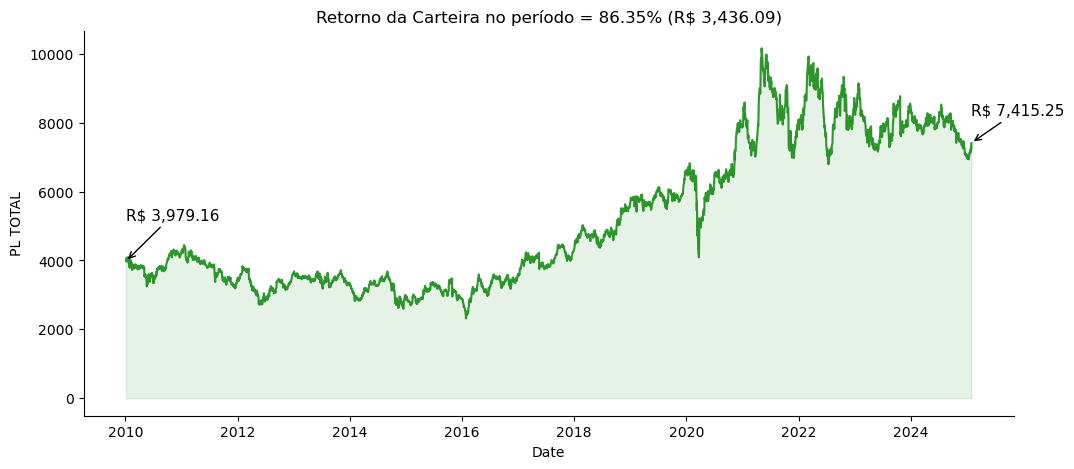

In [22]:
valor_aplicado = PL['PL TOTAL'].iloc[0]
rendimento = rhc * valor_aplicado
cor_desempenho = "green" if rhc > 0 else "red" 

plt.figure(figsize=(12,5))
plt.title(f'Retorno da Carteira no período = {rhc:.2%} (R$ {rendimento:,.2f})')

sns.lineplot(x=PL.index, y=PL['PL TOTAL'], color=cor_desempenho, alpha=0.8)
plt.fill_between(PL.index, PL['PL TOTAL'], color=cor_desempenho, alpha=0.1)

preco_inicio = PL['PL TOTAL'].iloc[0]
preco_fim = PL['PL TOTAL'].iloc[-1]

# Adicionando anotações
plt.annotate(f'R$ {preco_inicio:,.2f}', 
             xy=(PL.index[0], preco_inicio), 
             xytext=(0, 30),  # Offset da anotação
             textcoords='offset points', 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=11, color='black')

plt.annotate(f'R$ {preco_fim:,.2f}', 
             xy=(PL.index[-1], preco_fim), 
             xytext=(0, 20),  
             textcoords='offset points', 
             arrowprops=dict(facecolor='black', arrowstyle='->'),  
             fontsize=11, color='black')

sns.despine()
plt.show()

In [40]:
# Performance dos ativos
desem_ativos = pd.concat([pi, pf, PL.iloc[0], qtde_ativos, pesos, retornos*100], axis=1, join='inner',
                             keys=['Preço Início', 'Preço Final', 'PL Inicial', 'Quantidade','Peso','Retorno(%)'])

# Performance da carteira
pmi_c = (pi*qtde_ativos).sum()/qtde_ativos.sum()
pmf_c = (pf*qtde_ativos).sum()/qtde_ativos.sum()
pl_c =  (pi*qtde_ativos).sum()
qtd_c = qtde_ativos.sum()
peso_c = pesos.sum()
retorno_c = (retornos*pesos).sum()*100


desem_carteira = pd.DataFrame(data=[[pmi_c, pmf_c, pl_c, qtd_c, peso_c, retorno_c]], 
                             columns=['Preço Início', 'Preço Final', 'PL Inicial', 'Quantidade','Peso','Retorno(%)'],
                             index=['Carteira'])

# Juntando as performaces
performance = pd.concat([desem_ativos, desem_carteira], axis=0)
performance 

,Preço Início,Preço Final,PL Inicial,Quantidade,Peso,Retorno(%)
AGRO3.SA,10.200000,23.049999,1999.199963,196.0,0.502418,125.980389
BBAS3.SA,14.950000,27.639999,1001.649987,67.0,0.251724,84.882941
VALE3.SA,51.490002,55.029999,978.310032,19.0,0.245858,6.875116
Carteira,14.110496,26.295212,3979.159982,282.0,1.000000,86.352140


### Exemplos automatizado

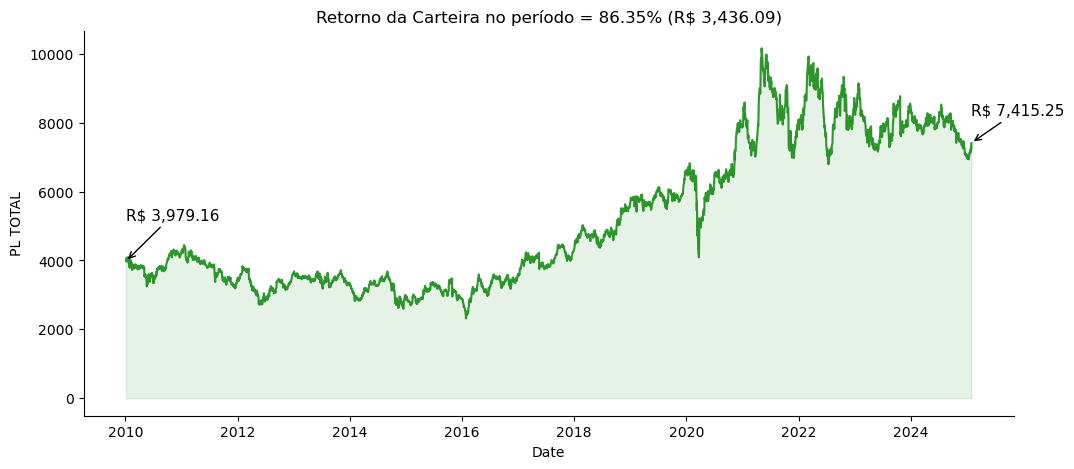

In [10]:
dt_inicio = '2010-01-01'
dt_final = '2025-01-30'
compras = {'VALE3.SA':1000, 'BBAS3.SA':1000, 'AGRO3.SA':2000}
retorno_carteira(compras, inicio=dt_inicio, fim=dt_final)

 #### Retornando os dados do período histórico

In [11]:
dados = retorno_carteira(compras, inicio=dt_inicio, fim=dt_final, plot_grafico=False, return_dados=True)
cotacao_periodo, resumo_periodo = dados

In [12]:
# histórico de variação do valor aplicado
cotacao_periodo

Ticker,AGRO3.SA,BBAS3.SA,VALE3.SA,PL TOTAL
Date,,,,
2010-01-04,1999.199963,1001.649987,978.310032,3979.159982
2010-01-05,1999.199963,991.600013,987.430023,3978.229999
2010-01-06,1999.199963,992.939980,1008.329994,4000.469936
2010-01-07,2056.039955,993.274987,1012.510017,4061.824960
2010-01-08,2056.039955,998.969990,1022.390026,4077.399971
...,...,...,...,...
2025-01-24,4355.119865,1783.540056,1007.569977,7146.229898
2025-01-27,4427.640030,1856.569939,1025.239983,7309.449951
2025-01-28,4466.840179,1844.510046,1000.350029,7311.700254


In [14]:
# Resumo
resumo_periodo

,Preço Início,Preço Final,PL Inicial,PL Final,Quantidade,Peso,Retorno(%)
AGRO3.SA,10.200000,23.049999,1999.199963,4517.799850,196.0,0.502418,125.980389
BBAS3.SA,14.950000,27.639999,1001.649987,1851.879959,67.0,0.251724,84.882941
VALE3.SA,51.490002,55.029999,978.310032,1045.569977,19.0,0.245858,6.875116
Carteira,14.110496,26.295212,3979.159982,7415.249786,282.0,1.000000,86.352140


 #### Performance de cada ativo durante esse período

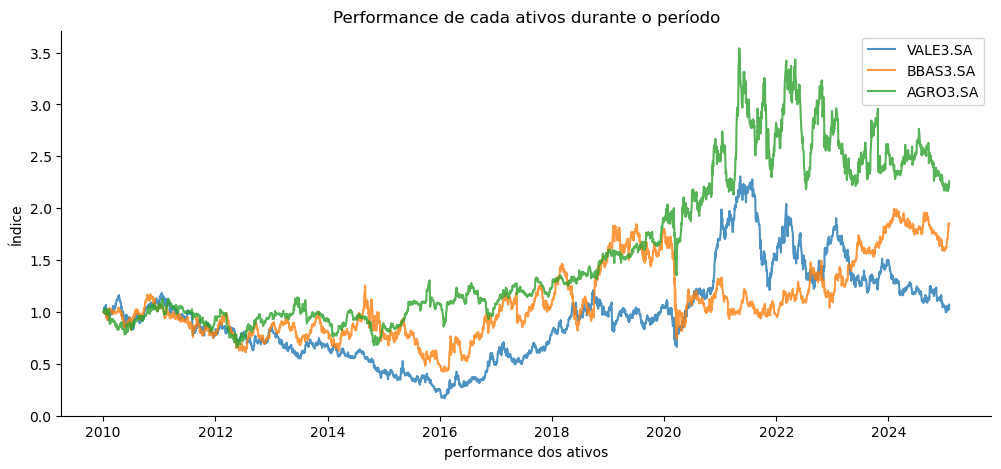

In [15]:
retorno_carteira(compras, inicio=dt_inicio, fim=dt_final, plot_grafico=False, plot_perf_ativos=True)